## Ali Padyav - 810199388

### AI - CA3

In [1]:
import pandas as pd
import numpy
import hazm
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from typing import Callable
from arabic_reshaper import reshape
from bidi.algorithm import get_display

<div dir="rtl">
Q1- در هردو روش stemming و lemmetization به نوعی به ریشه کلمه میرسیم. ولی در stemming کلمه فقط کوتاه میشود و تغییر دیگری ندارد. بنابراین ممکن است کلمه تولید شده بی‌معنی باشد. به همین دلیل دقت lemmetization بیشتر و به تبع آن زمان پردازشش هم بیشتر خواهد بود.

</div>

In [2]:
def preprocess(df: DataFrame) :   
    normalizer = hazm.Normalizer()
    lemmatizer = hazm.Lemmatizer()
    stemmer = hazm.Stemmer()

    stop_words = set(hazm.stopwords_list())
    punctuation_marks = {"." , "،" , "؛" , "«" , "»" , "(" , ")" , "-" , "_", ":" , "!" , '"' , '؟' , '?'}

    for i, data in df.iterrows():
        processed = []
        normalized = normalizer.normalize(data.content)
        words = hazm.word_tokenize(normalized)

        for word in words:
            if word in punctuation_marks:
                continue
            lemmetized = lemmatizer.lemmatize(word)
            if '#' in lemmetized:
                idx = lemmetized.index('#')
                lemmetized = lemmetized[:idx]
            if lemmetized and (lemmetized not in stop_words):
                processed.append(lemmetized)
                
        df['content'][i] = processed    


In [3]:
train_df = pd.read_csv('Dataset/train.csv')
preprocess(train_df)

In [4]:
categories = ['فناوری', 'سلامت', 'سیاسی', 'ورزشی','حوادث', 'فرهنگی/هنری']
cat_to_words = {cat: {} for cat in categories}
false_predicts = []

for index,data in train_df.iterrows():
    for word in data.content:
        cat_to_words[data.label][word] = cat_to_words[data.label].get(word, 0) + 1


<div dir="rtl">
Q2-<br>
evidence یا predictor Prior Probability احتمال دیده شدن کلمه x است. که از تقسیم شدن تعداد کلمات x به کل کلمات به دست می‌آید.<br>
likelihood احتمال دیده شدن کلمه x در دسته c را نشان میدهد که از تقسیم تعداد x دیده شده در دسته c به دست می‌آید.<br>
prior احتمال اینکه یک خبر در دسته c باشد. از تقسیم تعداد خبرهای c به تعداد کل خبرها به دست می‌آید.<br>
posterior خواسته اصلی ماست که احتمال بودن خبر در دسته c به شرط داشتن کلمه x را نشان میدهد.
</div>

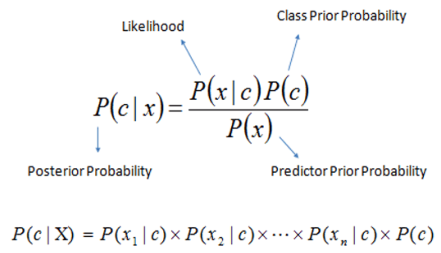

<div dir="rtl">
Q3- برای مثال معنی ماست در دو جمله (اشتباه از ماست) و (ماست گران شد) متفاوت است.
اگر از bigram ها استفاده کنیم، هر معنی به کلمه قبل و بعدش مربوط میشود. بنابراین میتوان معنی واقعی کلمه را با احتمال بیشتری درست تشخیص داد.<br>
استفاده از bigram تا حد خیلی زیاد مشکل را حل میکند. برای این مثال هم درست جواب میدهد.
</div>

<div dir="rtl">
Q4- وقتی کلمه ای در دسته ای وجود ندارد، احتمال حضورش در آن دسته را 0 در نظر میگیرم. در قانون بیز چون احتمالات در هم ضرب میشوند، اگر آن کلمه در خبری وجود داشته باشد، امکان این که آن خبر در دسته مذکور قرار بگیرد نخواهد بود.
</div>

<div dir="rtl">
Q5- میتوان از additive یا laplace smoothing استفاده کرد.<br>
α موجب میشود هیچگاه این کسر برابر 0 نشود. هرچه α بزرگتر شود، احتمالات به توزیح یکنواخت نزدیک تر میشود. بنابراین آن را 1 قرار میدهیم.
</div>


$$ P(x|c) = \frac{α + number\ of\ x\ appearances\ in\ class\ c}{total\ words\ in\ class\ c + α \times unique\ words\ in\ class\ c} $$

In [5]:
cat_to_unique_words = {cat: sum(cat_to_words[cat].values()) for cat in categories}

def non_additive_smothing(cat_probs: dict, word: str):
    for cat in categories:
        if word in cat_to_words[cat]:
            cat_probs[cat] *= cat_to_words[cat][word] / len(cat_to_words[cat])
        else:
            cat_probs[cat] = 0
    return cat_probs       

def additive_smothing(cat_probs: list, word:str):
    for cat in categories:
        if word in cat_to_words[cat]:
            cat_probs[cat] += (cat_to_words[cat][word] + 1) / (len(cat_to_words[cat]) + cat_to_unique_words[cat])
    return cat_probs       



<div dir="rtl">
تابع evaluate با استفاده از قانون بیز ابتدا دسته خبر را پیشبینی میکند و سپس با مقایسه آن با label دقت پیشبینی را میسنجد.
در اینجا تابع non_additive_smothing استفاده شده که همان بیز معمولی است.
</div>

In [6]:
def evaluate(df: DataFrame, evaluation_method: Callable):
    global false_predicts
    false_predicts.clear()
    total_class = {cat: 0 for cat in categories}
    detected_class = {cat: 0 for cat in categories}
    correct_class = {cat: 0 for cat in categories}
    correct_detected = 0

    for index,data in df.iterrows():
        cat_probs = {cat: 1 for cat in categories}
        for word in data.content:
            cat_probs = evaluation_method(cat_probs, word)

        max_chance = max(cat_probs, key=cat_probs.get)
        detected_class[max_chance] += 1
        total_class[data.label] += 1
        if max_chance == data.label:
            correct_class[max_chance] += 1
            correct_detected += 1
        else:
            if len(false_predicts) < 5:
                false_predicts.append(f"""{max_chance} ---> 
                {' '.join(data.content)}
                """)
                   

    f1s = {}
    for cat in categories:
        print(f"----{cat}----")
        precision = correct_class[cat] / detected_class[cat]
        recall = correct_class[cat] / total_class[cat]
        f1 = (2 * precision * recall) / (precision + recall)
        f1s[cat] = f1

        print(f"Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%", end='\n\n')

    accuracy = correct_detected / len(df)  
    macro_avg = sum(f1s.values()) / len(categories)
    weighted_avg = sum([f1s[cat] * total_class[cat] for cat in categories]) / len(df)
    micro_avg = accuracy

    print(f"Accuracy: {accuracy * 100:.5f}")
    print(f'Macro Avg: {macro_avg * 100:.5f}')
    print(f'Weighted Avg: {weighted_avg * 100:.5f}')
    print(f'Micro Avg: {micro_avg * 100:.5f}')


In [7]:
print('=========Non Additive Smoothing=========')
evaluate(train_df, non_additive_smothing)

=========Non Additive Smoothing=========
----فناوری----
Precision: 31.17%, Recall: 98.53%, F1: 47.36%

----سلامت----
Precision: 96.52%, Recall: 31.47%, F1: 47.46%

----سیاسی----
Precision: 93.59%, Recall: 52.60%, F1: 67.35%

----ورزشی----
Precision: 99.18%, Recall: 72.20%, F1: 83.56%

----حوادث----
Precision: 99.23%, Recall: 77.53%, F1: 87.05%

----فرهنگی/هنری----
Precision: 99.40%, Recall: 43.87%, F1: 60.87%

Accuracy: 62.70000
Macro Avg: 65.60875
Weighted Avg: 65.60875
Micro Avg: 62.70000


In [8]:
print('=========Additive Smoothing=========')
evaluate(train_df, additive_smothing)

=========Additive Smoothing=========
----فناوری----
Precision: 93.80%, Recall: 85.80%, F1: 89.62%

----سلامت----
Precision: 89.93%, Recall: 91.73%, F1: 90.83%

----سیاسی----
Precision: 79.87%, Recall: 88.33%, F1: 83.89%

----ورزشی----
Precision: 92.96%, Recall: 97.73%, F1: 95.29%

----حوادث----
Precision: 87.00%, Recall: 96.33%, F1: 91.43%

----فرهنگی/هنری----
Precision: 96.42%, Recall: 77.20%, F1: 85.75%

Accuracy: 89.52222
Macro Avg: 89.46612
Weighted Avg: 89.46612
Micro Avg: 89.52222


<div dir="rtl">
Q6- 
</div>

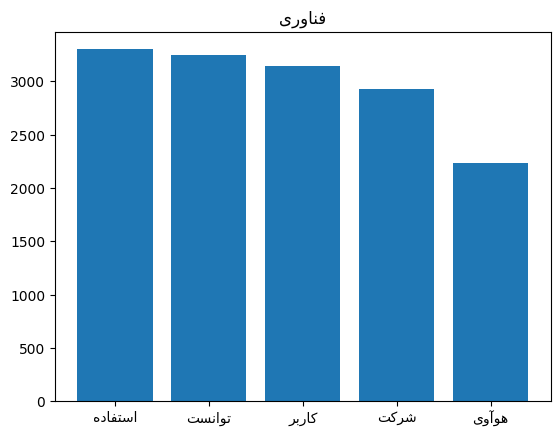

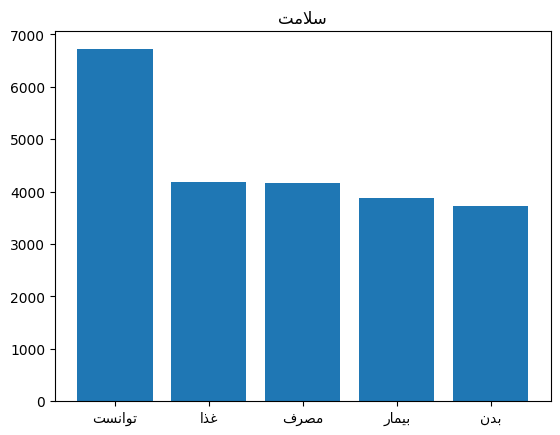

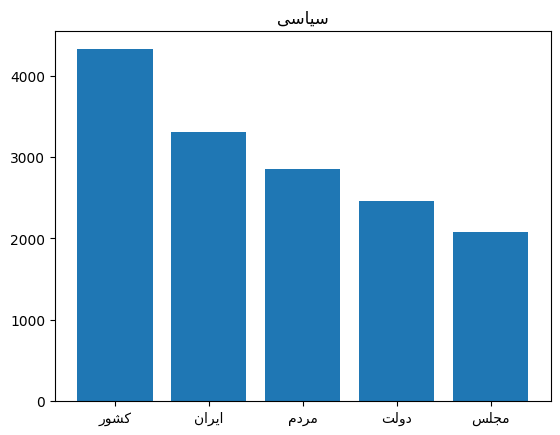

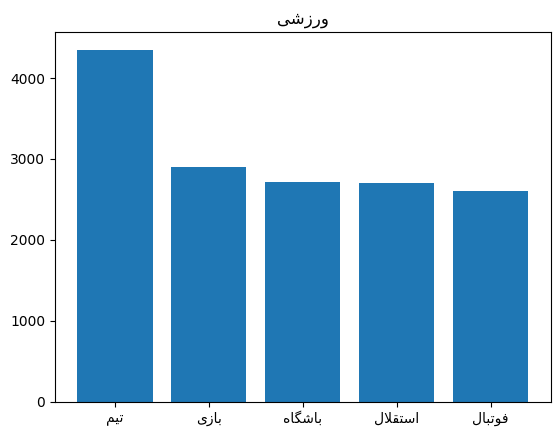

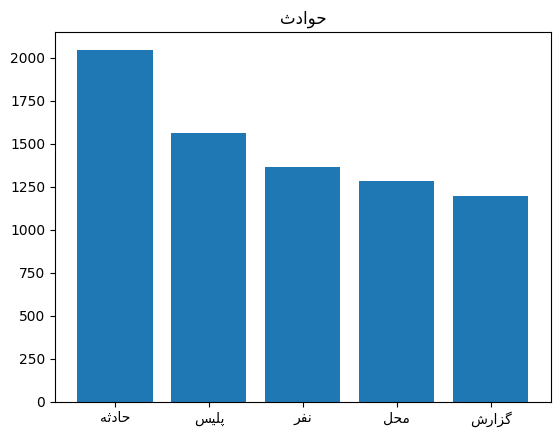

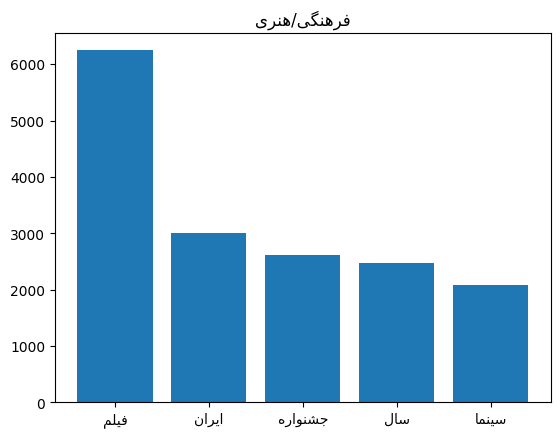

In [9]:
for cat in categories:
    most_frequent_words = dict(sorted(cat_to_words[cat].items(), key=lambda x: x[1] , reverse=True)[:5])
    words = most_frequent_words.keys()
    frequences = most_frequent_words.values()
    bar = plt.bar([get_display(reshape(word)) for word in words], frequences)
    plt.title(get_display(reshape(cat)))
    plt.show()


<div dir="rtl">
کلمه ایران در دو دسته سیاسی و هنری پرتکرار است. اینگونه کلمات را میتوان حذف کرد، چون تاثیر زیادی در پیشبینی ما ندارند.
</div>

<div dir="rtl">
Q7- اگر کلاسی به تعداد کم detect شده باشد، درصد percision زیاد میشود و برعکس اگر کلاسی زیاد detect شود، درصد recall زیاد میشود.<br>
مورد دوم را در دسته فناوری و مورد اول را در بقیه دسته ها مشاهده میکنیم.
</div>

<div dir="rtl">
Q8- این نوع میانگیری harmonic است. به این صورت که مقدار کمتر تاثیر بیشتری بر مقدار نهایی میگذارد.
</div>

<div dir="rtl">
Q9-<br>
Macro میانگین یکی از 3 معیار (precision, recall, F1) بین دسته هاست.<br>
Weighted به هر کلاس وزنی میدهد. این وزن با تعداد نمونه ها در آن کلاس رابطه مستقیم دارد.<br>
Micro مقدار F1 را با استفاده از true positives، false negatives و false positives به دست می‌آورد.
</div>

<div dir="rtl">
Q10-
</div>

In [10]:
test_df = pd.read_csv('Dataset/test.csv')
preprocess(test_df)

In [11]:
print('=========Non Additive Smoothing=========')
evaluate(test_df, non_additive_smothing)

=========Non Additive Smoothing=========
----فناوری----
Precision: 18.22%, Recall: 100.00%, F1: 30.83%

----سلامت----
Precision: 90.48%, Recall: 10.73%, F1: 19.19%

----سیاسی----
Precision: 77.97%, Recall: 23.00%, F1: 35.52%

----ورزشی----
Precision: 95.56%, Recall: 22.63%, F1: 36.60%

----حوادث----
Precision: 86.21%, Recall: 12.50%, F1: 21.83%

----فرهنگی/هنری----
Precision: 84.62%, Recall: 18.33%, F1: 30.14%

Accuracy: 29.95516
Macro Avg: 29.01761
Weighted Avg: 29.08035
Micro Avg: 29.95516


In [12]:
print('=========Additive Smoothing=========')
evaluate(test_df, additive_smothing)

=========Additive Smoothing=========
----فناوری----
Precision: 92.21%, Recall: 84.52%, F1: 88.20%

----سلامت----
Precision: 90.32%, Recall: 94.92%, F1: 92.56%

----سیاسی----
Precision: 84.86%, Recall: 92.50%, F1: 88.52%

----ورزشی----
Precision: 93.91%, Recall: 97.37%, F1: 95.61%

----حوادث----
Precision: 86.94%, Recall: 96.50%, F1: 91.47%

----فرهنگی/هنری----
Precision: 97.83%, Recall: 75.00%, F1: 84.91%

Accuracy: 90.40359
Macro Avg: 90.20993
Weighted Avg: 90.26587
Micro Avg: 90.40359


<div dir="rtl">
Q11- در حالت بیز معمولی دقت پیشبینی بسیار پایین است. حتی نسبت به نتایج قبلی. چون مدل ما توسط داده های قبلی ساخته شد و احتمال اینکه کلمه های داده جدید در مدل ما نباشند بسیار بیشتر است.
و در حالت additive smooth این مشکل رفع شده است.
</div>

<div dir="rtl">
Q12-
</div>

In [13]:

for false_predict in false_predicts[:5]:
    print(false_predict)

سیاسی ---> 
                چهارشنبه تیر ۱۴۰۱ اتفاق نادر جالب رخ قطعا صورت تصادف برنامه‌ریزی اطلاع شکل هم‌زمان محل انجمن صنف روزنامه‌نگار استان تهران رونما صدا‌و‌سیما معاون سازمان کلیات اگرچه واژه مشترک‌اند ربط شباهت سند سند تعبیر دکتر وب‌۲ سر گذاشته زود وب‌۳ رادیو تلویزیون رسانه مدرن تعبیر رسانه تلویزیون معنی عام جهانی مشخصا صدا سیما ایران رایگان گسترده وقت‌گذرانی ارتباط رایگان جهت پرداخت حق اشتراک وگرنه بودجه جیب ملت تأمین رسانه واقعا رسانه بودجه حکومت مخاطب‌محور تعبیر رسانه ملی باقی موارد ترجیح مفاهیم ایدیولوژیک استفاده واقع عرصه جنگ واژه جنگ قرارگاه حجم عظیم پرسنل بودجه کلان انحصار چنگ انداختن شبکه نمایش خانگی توجیه مراد واژه ملی واقعا ملی معطوف ایران مراد ملی معطوف نظام سیاسی گرنه ملی زبان ملی سینما ملی موسیقی ملی بها چندان نوشت آیین وابستگی دولت حکومت شایبه تبلیغاتی حضور چهره شاخص رسانه استاد شاخص ارتباطات معیار حرفه‌ای جهانی شناخته‌شده برگزار ذیل عنوان رسانه ملی اهداف سیاسی ایدیولوژیک جدا معیار شناخته رسانه حدس زد بی‌حضور عالمان رشته اداری محتمل معاون تحصیلات مرتبط صفت حاضر اتفا

<div dir="rtl">
به دلیل اشتراک کلمات در دسته های مختلف این اتفاق می‌افتد. مثلا دسته های سیاسی و حوادث میتوانند نزدیک به هم باشند. یکی از راه های کم کردن این خطا استفاده از Bigram است. زیرا باعث میشود بین کلمات مشترک در دسته های مختلف تمایز به وجود آید.
</div>